# Frame Differences

This notebook demonstrates that the images with higher speeds differ more than the images with lower speeds.

## Setup
- Download and unpack training data
- Create DonkeyCar project and load configuration

In [1]:
%load_ext autoreload
%autoreload 2
import os
# do we have the correct env loaded?
assert 'donkey2' == os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_DEFAULT_ENV']

In [2]:
![ ! -d "mycar/" ] && \
donkey createcar --path mycar && \
cp config/myconfig.py mycar/

In [3]:
import sys
sys.path.append('donkeycar')
sys.path.append('src')

In [4]:
import numpy as np
import donkeycar as dk
cfg = dk.load_config(config_path='mycar/config.py')
cfg.SEQUENCE_LENGTH = 2

________             ______                   _________              
___  __ \_______________  /___________  __    __  ____/_____ ________
__  / / /  __ \_  __ \_  //_/  _ \_  / / /    _  /    _  __ `/_  ___/
_  /_/ // /_/ /  / / /  ,<  /  __/  /_/ /     / /___  / /_/ /_  /    
/_____/ \____//_/ /_//_/|_| \___/_\__, /      \____/  \__,_/ /_/     
                                 /____/                              

using donkey v4.3.5 ...
loading config file: mycar/config.py
loading personal config over-rides from myconfig.py


### Load tubs

In [5]:
from dataloader import load_records
fast_speed_data = load_records('faster-autodrive', cfg, 'data', None)
slow_speed_data = load_records('slower-autodrive', cfg, 'data', None)



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/faster-autodrive']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/faster-autodrive/catalog_20.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['data/slower-autodrive']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/data/slower-autodrive/catalog_20.catalog


### On average, do two consecutive images/frames differ more for bigger speeds?

In [7]:
def mse(image1, image2):
    return np.array((image1 - image2)**2).mean()

def rmse(image1, image2):
    return np.sqrt(mse(image1, image2))

In [8]:
from donkeycar.pipeline.augmentations import ImageAugmentation
from skimage.metrics import normalized_root_mse, mean_squared_error
import pandas as pd

transformation = ImageAugmentation(cfg, 'TRANSFORMATIONS')
tub_records = dict(fast=fast_speed_data, slow=slow_speed_data)
for_df = []
for speed, records in tub_records.items():
    for (first_tubrecord, second_tubrecord) in records:
        first_image = first_tubrecord.image()
        first_image = transformation.run(first_image)

        second_image = second_tubrecord.image()
        second_image = transformation.run(second_image)

        my_mse = mse(second_image, first_image)
        mse_ = mean_squared_error(second_image, first_image)
        rmse_ = rmse(second_image, first_image)
        nrmse = normalized_root_mse(second_image, first_image)

        tubrecord_index = first_tubrecord.underlying['_index']
        for_df.append([tubrecord_index, speed, mse_, rmse_, nrmse, my_mse])

df = pd.DataFrame(for_df, columns=['tubrecord_index', 'speed', 'MSE', 'RMSE', 'NRMSE', 'MY_MSE'])
df

,tubrecord_index,speed,MSE,RMSE,NRMSE,MY_MSE
0,51,fast,12.500174,3.308265,0.023313,10.944618
1,52,fast,13.115660,3.330014,0.023891,11.088993
2,53,fast,15.118993,3.457535,0.025629,11.954549
3,54,fast,0.000000,0.000000,0.000000,0.000000
4,55,fast,29.372847,4.414567,0.035505,19.488403
...,...,...,...,...,...,...
39559,20465,slow,6.828021,2.590843,0.019883,6.712465
39560,20466,slow,8.200521,2.838714,0.021756,8.058299
39561,20467,slow,5.662361,2.360820,0.018087,5.573472
39562,20468,slow,3.722743,1.929441,0.014688,3.722743


In [9]:
df.groupby('speed').mean()

,tubrecord_index,MSE,RMSE,NRMSE,MY_MSE
speed,,,,,
fast,10056.610084,38.238296,4.13226,0.043525,18.104916
slow,10255.434108,22.354597,3.65801,0.033508,14.077017


In [10]:
df.to_csv('image_diffs.csv.gz', index=False)

df.describe()

,tubrecord_index,MSE,RMSE,NRMSE,MY_MSE
count,39564.000000,39564.000000,39564.000000,39564.000000,39564.000000
mean,10158.655394,30.086077,3.888854,0.038384,16.037619
std,5833.540996,23.977366,0.956273,0.013705,8.879700
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5104.000000,14.606745,3.343151,0.028243,11.176658
50%,10199.500000,21.762483,3.688691,0.035253,13.606441
75%,15145.000000,37.550469,4.196015,0.045332,17.606545
max,20469.000000,805.490972,10.738088,0.217695,115.306528


In [11]:
import pandas as pd

df = pd.read_csv('image_diffs.csv.gz')

df.groupby('speed').MSE.mean(), df.groupby('speed').RMSE.mean(), df.groupby('speed').NRMSE.mean()

(speed
 fast    38.238296
 slow    22.354597
 Name: MSE, dtype: float64,
 speed
 fast    4.13226
 slow    3.65801
 Name: RMSE, dtype: float64,
 speed
 fast    0.043525
 slow    0.033508
 Name: NRMSE, dtype: float64)

In [12]:
df.describe()


,tubrecord_index,MSE,RMSE,NRMSE,MY_MSE
count,39564.000000,39564.000000,39564.000000,39564.000000,39564.000000
mean,10158.655394,30.086077,3.888854,0.038384,16.037619
std,5833.540996,23.977366,0.956273,0.013705,8.879700
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5104.000000,14.606745,3.343151,0.028243,11.176658
50%,10199.500000,21.762483,3.688691,0.035253,13.606441
75%,15145.000000,37.550469,4.196015,0.045332,17.606545
max,20469.000000,805.490972,10.738088,0.217695,115.306528


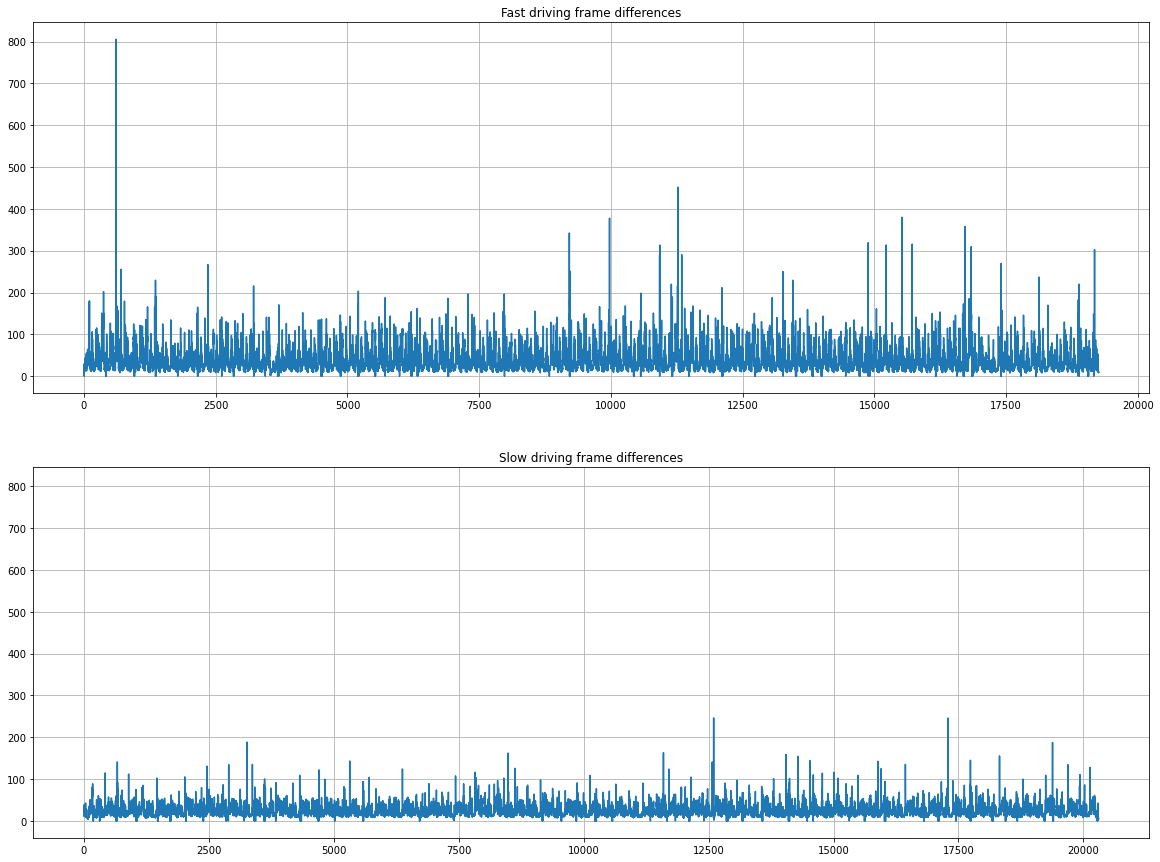

In [24]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, sharey='all', figsize=(20, 15))
ax1.plot(df[df.speed == 'fast'].MSE)
ax1.set_title('Fast driving frame differences')
ax1.grid()

ax2.plot(df[df.speed == 'slow'].reset_index().MSE)
ax2.set_title('Slow driving frame differences')
ax2.grid()

### Conclusion
Images are more different for faster speeds
